<a href="https://colab.research.google.com/github/hechen2020/19ma573HuixinChen/blob/master/src/btcs_stability_heat_1d_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# other parameters
al = 1
dx = .2 #space mesh size
rho = 1. #conditinal number, to be less than .5 for the stability
dt = rho*(dx**2)/al #time step size

In [0]:
# initial function f
def init_f(x):
  return np.sin(np.pi*x)

In [0]:
# true function
def true_f(x,t):
  return np.exp(-np.pi**2 * t)*np.sin(np.pi * x)

**Use ftcs to solve heat equation and find subnorm of error function**

In [0]:
def ftcs(a,b,nt,dx,dt,rho):
  nx = int((b-a)/dx)
  u = np.zeros((nt,nx))
  
  for x in range(0,nx):
    u[0][x] = init_f(a+x*dx)
    
  for t in range(0,nt-1):
    for x in range(1,nx-1):
      u[t+1][x] = rho*(u[t][x-1]) + (1-2*rho)*(u[t][x]) + rho*(u[t][x+1])
      
      
  return u

In [11]:
ftcs_sol = ftcs(0,1.4,200,dx,dt,rho)
print(ftcs_sol)

[[ 0.00000000e+00  5.87785252e-01  9.51056516e-01  9.51056516e-01
   5.87785252e-01  1.22464680e-16]
 [ 0.00000000e+00  3.63271264e-01  5.87785252e-01  5.87785252e-01
   3.63271264e-01  0.00000000e+00]
 [ 0.00000000e+00  2.24513988e-01  3.63271264e-01  3.63271264e-01
   2.24513988e-01  0.00000000e+00]
 ...
 [ 0.00000000e+00  2.07993714e+65 -3.36540899e+65  3.36540899e+65
  -2.07993714e+65  0.00000000e+00]
 [ 0.00000000e+00 -5.44534613e+65  8.81075512e+65 -8.81075512e+65
   5.44534613e+65  0.00000000e+00]
 [ 0.00000000e+00  1.42561012e+66 -2.30668564e+66  2.30668564e+66
  -1.42561012e+66  0.00000000e+00]]


In [0]:
def error_fcn(a,b,nt,dx,dt,sol):
  nx = int((b-a)/dx)
  e = np.zeros((nt,nx))
  
  for t in range(nt):
    for x in range(nx):
      e[t][x] = np.abs(sol[t][x]-true_f(a+x*dx,t*dt))
  return e

In [17]:
err = error_fcn(0, 1.4, 200, dx, dt, ftcs_sol)
superr = np.max(err)
print('the supnorm of error function is ' + str(superr))
#print(err)

the supnorm of error function is 2.3066856359409035e+66


Since the supnorm of the ftcs sol is sufficiently large, we can say the ftcs method diverge and supnorm is $\infty$

[0.  0.2 0.4 0.6 0.8 1. ]
[ 0.00000000e+00 -4.18560397e+02  6.77244950e+02 -6.77244950e+02
  4.18560398e+02  7.21583461e-25]
[ 0.00000000e+00  1.09580535e+03 -1.77305030e+03  1.77305030e+03
 -1.09580535e+03  4.86221301e-25]
[ 0.00000000e+00 -2.86885564e+03  4.64190594e+03 -4.64190594e+03
  2.86885565e+03  3.27628288e-25]


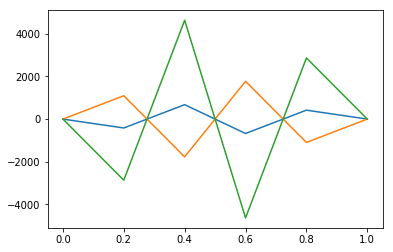

In [18]:
xx = np.arange(0,1.2,.2)
print(xx)
error1 = np.zeros(6)
for i in range(len(error1)):
  error1[i] = true_f(xx[i], 1.92) - ftcs_sol[int(1.92/dt)][i]
print(error1)
error2 = np.zeros(6)
for i in range(len(error2)):
  error2[i] = true_f(xx[i], 1.96) - ftcs_sol[int(1.96/dt)][i]
print(error2)
error3 = np.zeros(6)
for i in range(len(error3)):
  error3[i] = true_f(xx[i], 2.00) - ftcs_sol[int(2.00/dt)][i]
print(error3)
plt.plot(xx,error1)
plt.plot(xx,error2)
plt.plot(xx,error3)

**Use btcs to solve heat equation and find subnorm of error function**

BTCS can be expressed as

$$
\begin{bmatrix}
   1+2\rho & -\rho & 0 & \dots  & 0 \\
    -\rho & \ddots & \ddots & \ddots  & \vdots \\
    0 & \ddots & \ddots & \ddots & 0 \\
    \vdots & \ddots & \ddots& \ddots & -\rho\\
    0 & \dots & 0 & -\rho  & 1+2\rho
\end{bmatrix}
\times
\begin{bmatrix}
   u_{0,k+1} \\
   u_{1,k+1} \\
   \vdots \\
   \vdots\\
   u_{n,k+1}
\end{bmatrix}
=
\begin{bmatrix}
   u_{0,k} \\
   u_{1,k} \\
   \vdots \\
   \vdots\\
   u_{n,k}
\end{bmatrix}
$$

so the upper level is the inverse of the matrix times the lower level

In [0]:
def btcs(a, b, nt, dx, dt, rho):
  nx = int((b-a)/dx)
  u = np.zeros((nt,nx))
  
  ld = np.repeat(-rho,nx-1)#lower diag
  md = np.repeat(1+2*rho,nx)#main diag
  ud = np.repeat(-rho,nx-1)#upper diag
  
  A = np.diag(ld, -1) + np.diag(md, 0) + np.diag(ud, 1)#matrix
  
  for x in range(0,nx):
    u[0][x] = init_f(a+x*dx)
  
  for t in range(0,nt-1):
    u[t+1][:] = np.linalg.inv(A).dot(u[t][:])
  
  return u
  
  

In [20]:
btcs_sol = btcs(0,1.4,200,dx,dt,rho)
print(btcs_sol)

[[0.00000000e+00 5.87785252e-01 9.51056516e-01 9.51056516e-01
  5.87785252e-01 1.22464680e-16]
 [1.63586694e-01 4.90760082e-01 7.20908299e-01 7.20908299e-01
  4.90760082e-01 1.63586694e-01]
 [1.93873995e-01 4.18035290e-01 5.69471795e-01 5.69471795e-01
  4.18035290e-01 1.93873995e-01]
 ...
 [1.19095986e-16 2.14603551e-16 2.67606252e-16 2.67606252e-16
  2.14603551e-16 1.19095986e-16]
 [9.94071758e-17 1.79125541e-16 2.23365896e-16 2.23365896e-16
  1.79125541e-16 9.94071758e-17]
 [8.29732967e-17 1.49512714e-16 1.86439305e-16 1.86439305e-16
  1.49512714e-16 8.29732967e-17]]


In [21]:
err = error_fcn(0, 1.4, 200, dx, dt, btcs_sol)
superr = np.max(err)
print('the supnorm of error function is ' + str(superr))
#print(err)

the supnorm of error function is 0.19387399477467307


**Plot three error curves with $t = 1.92, 1.96, 2.00$ for btcs**

*the ranges have been slightly changed so the number of steps for t are integers*

[0.  0.2 0.4 0.6 0.8 1. ]
[-7.04377560e-05 -1.26920987e-04 -1.58266597e-04 -1.58266597e-04
 -1.26920987e-04 -7.04377560e-05]
[-5.87930679e-05 -1.05939114e-04 -1.32103048e-04 -1.32103048e-04
 -1.05939114e-04 -5.87930679e-05]
[-4.90734661e-05 -8.84257579e-05 -1.10264533e-04 -1.10264533e-04
 -8.84257579e-05 -4.90734661e-05]


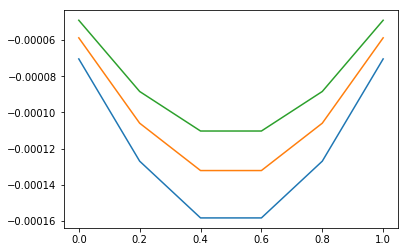

In [22]:
xx = np.arange(0,1.2,.2)
print(xx)
error1 = np.zeros(6)
for i in range(len(error1)):
  error1[i] = true_f(xx[i], 1.92) - btcs_sol[int(1.92/dt)][i]
print(error1)
error2 = np.zeros(6)
for i in range(len(error2)):
  error2[i] = true_f(xx[i], 1.96) - btcs_sol[int(1.96/dt)][i]
print(error2)
error3 = np.zeros(6)
for i in range(len(error3)):
  error3[i] = true_f(xx[i], 2.00) - btcs_sol[int(2.00/dt)][i]
print(error3)
plt.plot(xx,error1)
plt.plot(xx,error2)
plt.plot(xx,error3)